<a href="https://colab.research.google.com/github/jimhhh898989/2022_SummerDL/blob/main/LSTM_sentimental_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import functools
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
!pip install datasets
import datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 6.4 MB/s 
     |████████████████████████████████| 101 kB 13.9 MB/s 
     |████████████████████████████████| 141 kB 73.6 MB/s 
     |████████████████████████████████| 212 kB 68.1 MB/s 
     |████████████████████████████████| 115 kB 71.6 MB/s 
     |████████████████████████████████| 596 kB 61.0 MB/s 
     |████████████████████████████████| 127 kB 70.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [27]:
seed = 0

torch.manual_seed(seed)

In [28]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [29]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [30]:
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    length = len(tokens)
    return {'tokens': tokens, 'length': length}

In [31]:
max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [32]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [33]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [34]:
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

In [35]:
vocab.set_default_index(unk_index)

In [36]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

In [37]:
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})


  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [38]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label', 'length'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label', 'length'])

In [39]:
train_data[0]

{'label': tensor(1),
 'length': tensor(194),
 'ids': tensor([    5,    56,    23,     4,     6,    34,    12,     9,   253,   112,
             5,   659,     7,   206,     3,   941,    25,     2,   848,  9124,
            24,    10,   228,    46,    10,    85,    62,   181,    27,   138,
            83,    10,   800,    44,     2,   410,  8495,     4,     6,    12,
            31,     8,   612,    92,    85,    49,  2984,    13,  3876,     3,
            75,    46,    62,    13,     2,   194,    57,    50,    17,     5,
             0,   332,   763,     8,     0,    62,    57,    50,   393,   227,
             2,   855,    17,   397,    39,     2,  1841,     7,     2,   599,
            27,    72,    14,    17,   421,   393,    17,    14,     5,  4171,
           988,    64,    20,    72,     2,   332,    17,   486,    58,  1027,
            57,    13,   343,     4,    58,   312,     5,   179,     4,    22,
            11,   244,  3207,    62,   170,    44,  2640,   793,    83,     2,


In [40]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, 
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction


In [41]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, 
             pad_index)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,091,702 trainable parameters


In [43]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [44]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21603, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [45]:
vectors = torchtext.vocab.FastText()

.vector_cache/wiki.en.vec: 6.60GB [06:18, 17.4MB/s]                            
100%|██████████| 2519370/2519370 [03:55<00:00, 10708.42it/s]


In [46]:
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

In [48]:
model = model.to(device)
criterion = criterion.to(device)

In [49]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label}
    return batch

In [50]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [51]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [52]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [53]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [54]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]
epoch: 1
train_loss: 0.636, train_acc: 0.623
valid_loss: 0.480, valid_acc: 0.777
evaluating...: 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]
epoch: 2
train_loss: 0.487, train_acc: 0.770
valid_loss: 0.421, valid_acc: 0.818
evaluating...: 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]
epoch: 3
train_loss: 0.394, train_acc: 0.829
valid_loss: 0.376, valid_acc: 0.832
evaluating...: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
epoch: 4
train_loss: 0.340, train_acc: 0.856
valid_loss: 0.376, valid_acc: 0.842
evaluating...: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
epoch: 5
train_loss: 0.324, train_acc: 0.865
valid_loss: 0.331, valid_acc: 0.862
evaluating...: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]
epoch: 6
train_loss: 0.278, train_acc: 0.889
valid_loss: 0.295, valid_acc: 0.876
evaluating...: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]
epoch: 7
train_loss: 0.246, train_acc: 0.903
valid_loss: 0.287, valid_acc

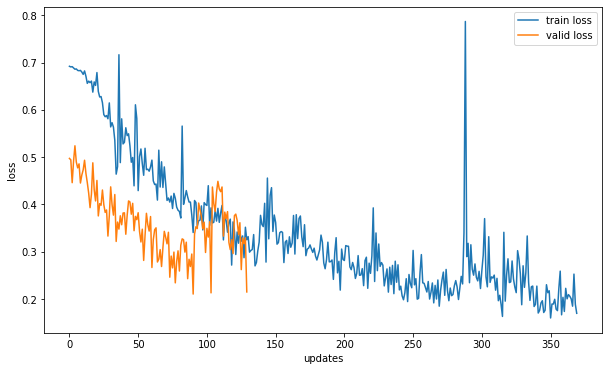

In [55]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

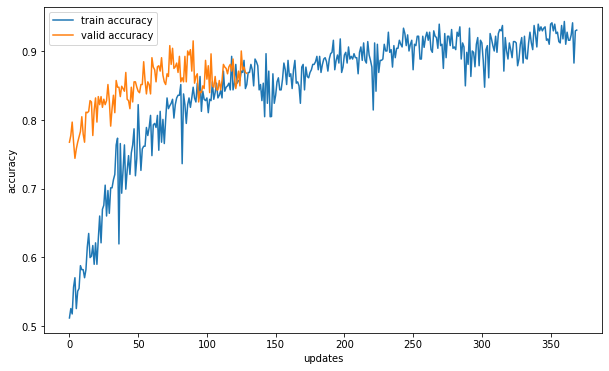

In [56]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');


In [57]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 49/49 [00:20<00:00,  2.41it/s]
test_loss: 0.315, test_acc: 0.864
